# QuantQC Analysis — Python

This notebook recreates the analysis from `Analysis.R` using the Python `quantqc` package.

Two workflows are demonstrated:
1. **plexDIA** — 3-plex mTRAQ / DIA data analyzed with DIA-NN
2. **pSCoPE** — 32-plex TMT / DDA data analyzed with MaxQuant

In [22]:
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'python'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import quantqc as qqc


---
## 1. plexDIA Analysis (DIA / mTRAQ 3-plex)

### 1.1 File paths — UPDATE THESE

In [23]:
# DIA-NN report.tsv — download from MassIVE repository
data_path = "/Users/andrewleduc/Desktop/app_note/report.tsv"

# Linker CSV mapping raw file names to well/plate
linker_path = os.path.join(os.getcwd(), "plexDIA/linker.csv")

# CellenONE isolation files — one per cell type
all_cells = {
    "Melanoma": os.path.join(os.getcwd(), "plexDIA/Melanoma.xls"),
    "PDAC":     os.path.join(os.getcwd(), "plexDIA/PDAC.xls"),
    "Monocyte": os.path.join(os.getcwd(), "plexDIA/Monocyte.xls"),
}

### 1.2 Import data and build cell × peptide matrix

In [24]:
# Generate QQC object from DIA-NN report
AppNote = qqc.diann_to_qqc(data_path, linker_path, plex=3, carrier=False)
print(f"Raw data shape: {AppNote.raw_data.shape}")

Raw data shape: (3430637, 20)


In [25]:
# Normalize to reference channel, filter by Channel Q Value,
# build peptide × cell matrix
AppNote = qqc.cell_x_peptide(AppNote, tq_val=1, ch_q_val=.01)
print(f"Peptide matrix: {AppNote.matrices.peptide.shape[0]} peptides × {AppNote.matrices.peptide.shape[1]} cells")

Peptide matrix: 40667 peptides × 121 cells


### 1.3 Map CellenONE metadata

In [26]:
AppNote = qqc.link_cellenone_raw(AppNote, all_cells)

AppNote.meta_data

,ID,diameter,sample,label,injectWell,plate,prot_total,Run,Well,plate_linker,Order
0,B101.0,17.22,Monocyte,0,B10,1,26.422038,DDM_Slot1-34_1_1367,B10,1,2
1,B101.4,28.79,PDAC,4,B10,1,28.672747,DDM_Slot1-34_1_1367,B10,1,2
2,B111.0,30.62,PDAC,0,B11,1,28.632106,DDM_Slot1-35_1_1368,B11,1,3
3,B111.4,21.73,Melanoma,4,B11,1,28.042971,DDM_Slot1-35_1_1368,B11,1,3
4,B111.8,21.97,Monocyte,8,B11,1,27.345458,DDM_Slot1-35_1_1368,B11,1,3
...,...,...,...,...,...,...,...,...,...,...,...
116,E81.0,21.36,Monocyte,0,E8,1,26.385204,DDM_Slot1-104_1_1413,E8,1,34
117,E81.4,24.84,PDAC,4,E8,1,28.363777,DDM_Slot1-104_1_1413,E8,1,34
118,E81.8,26.67,Melanoma,8,E8,1,27.371353,DDM_Slot1-104_1_1413,E8,1,34
119,E91.0,23.95,Melanoma,0,E9,1,28.116200,DDM_Slot1-105_1_1414,E9,1,35


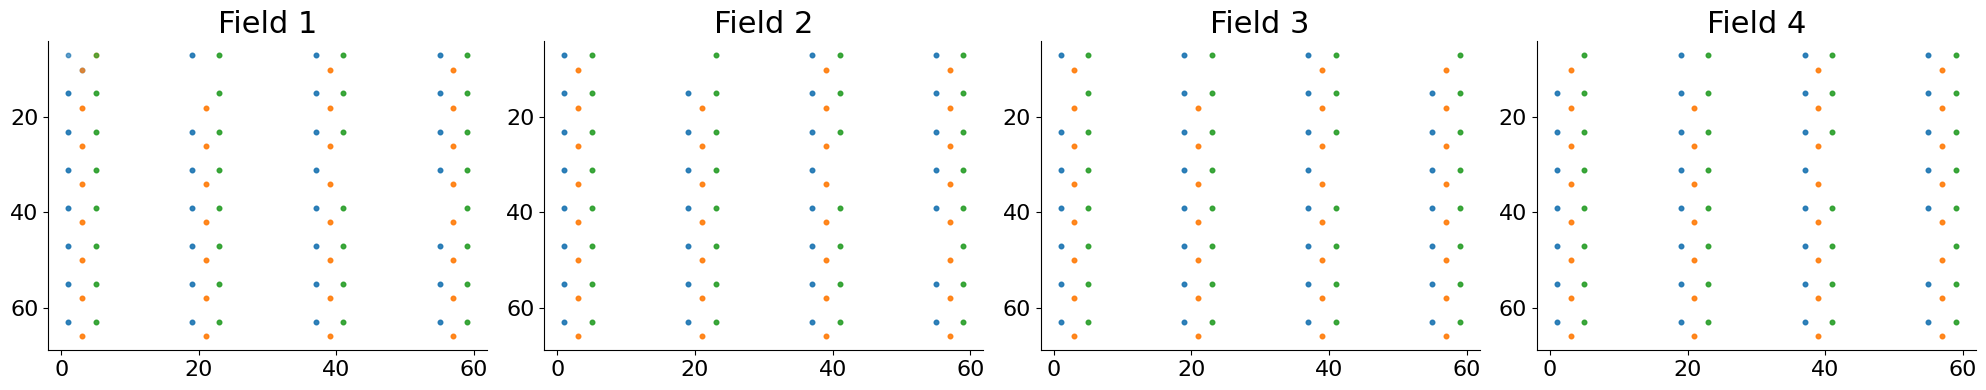

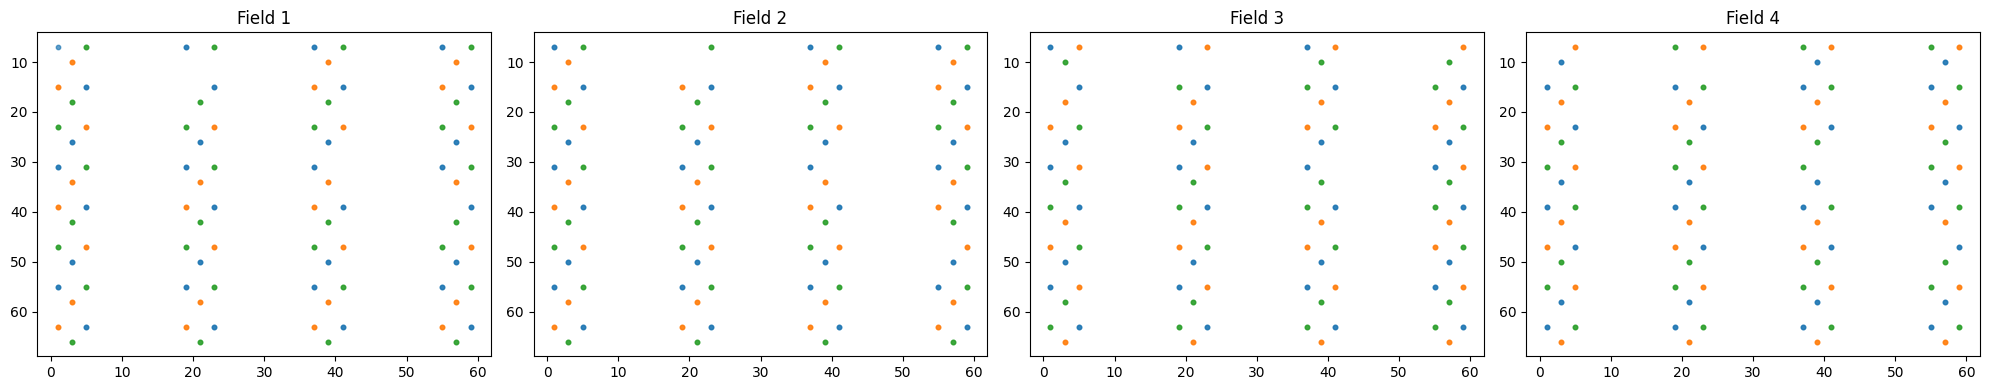

In [27]:
# Plot experimental design on glass slide
from quantqc.cellenone import plot_slide_layout_celltype, plot_slide_layout_label

fig = plot_slide_layout_celltype(AppNote)
plt.show()

fig = plot_slide_layout_label(AppNote)
plt.show()

### 1.4 LC/MS run order statistics

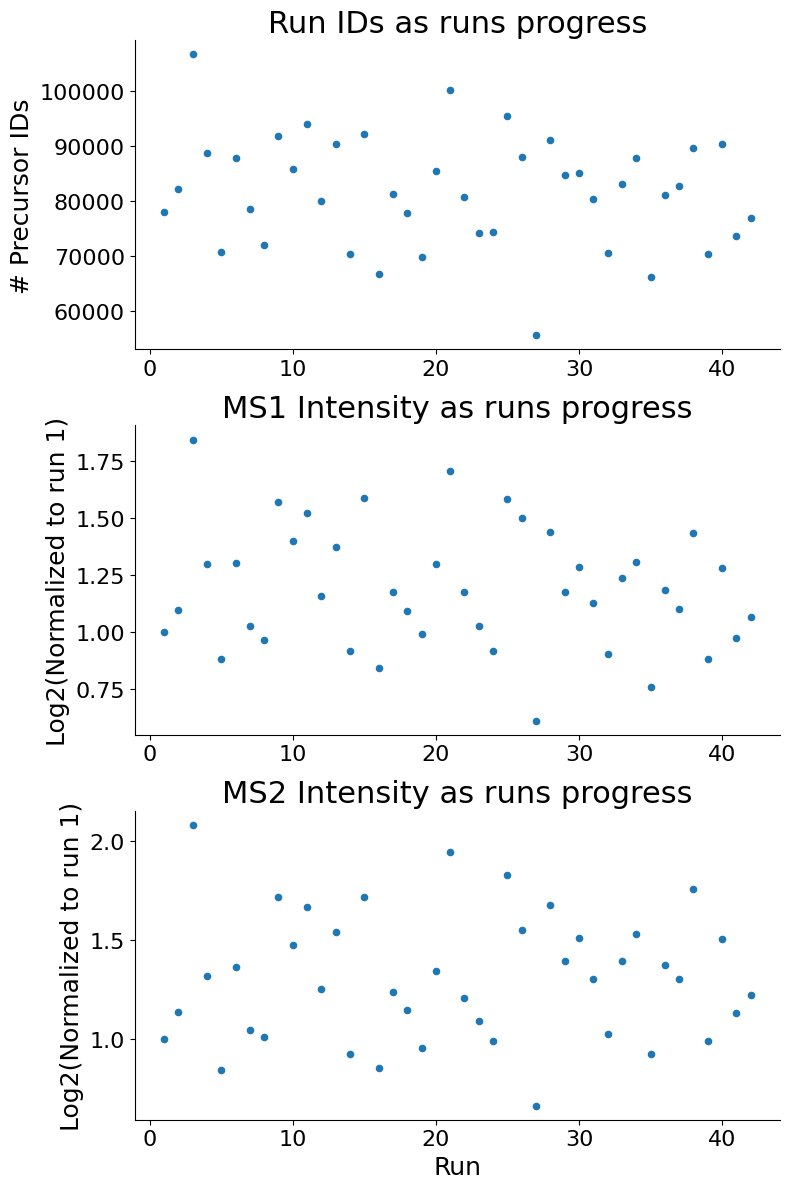

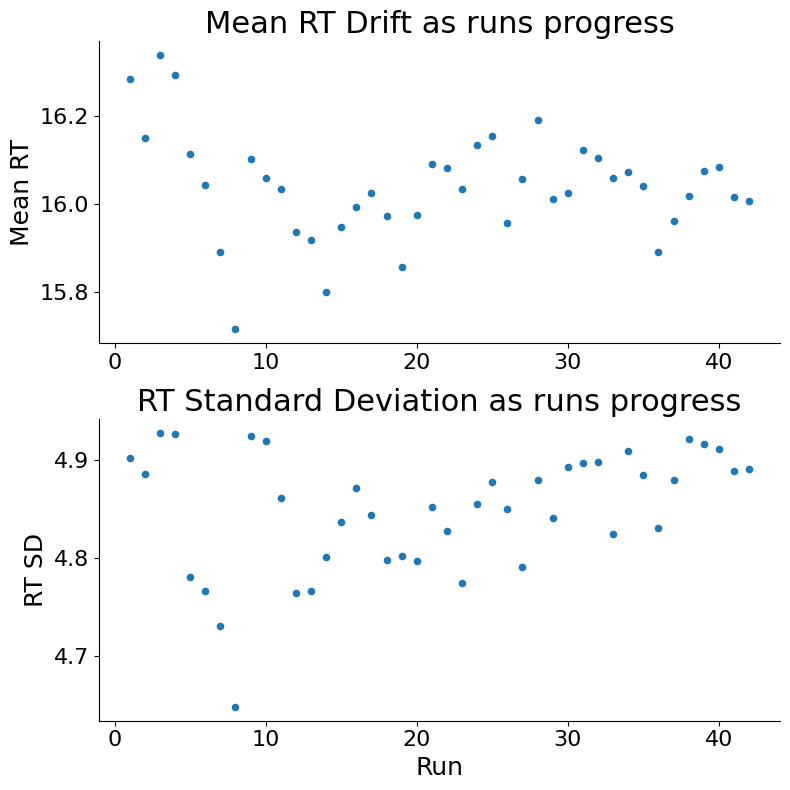

In [28]:
from quantqc.lcms import calculate_run_order_statistics, plot_intensity_drift, plot_rt_drift

AppNote = calculate_run_order_statistics(AppNote)

fig = plot_intensity_drift(AppNote)
plt.show()

fig = plot_rt_drift(AppNote)
plt.show()

### 1.5 Negative controls

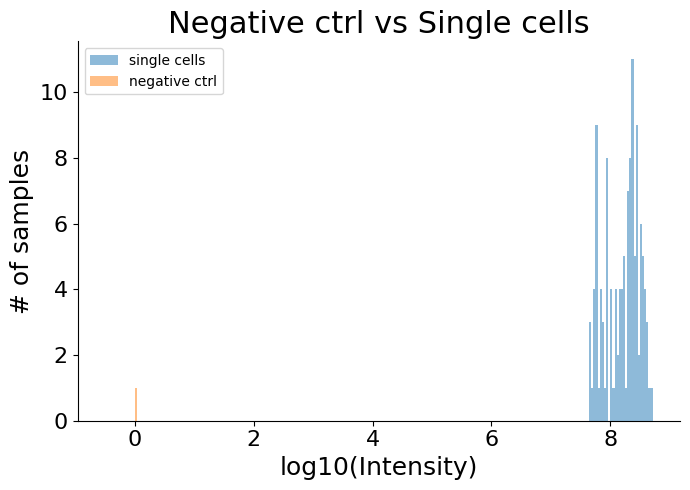

In [29]:
AppNote = qqc.evaluate_negative_controls(AppNote)

fig = qqc.plot_neg_ctrl(AppNote)
plt.show()

### 1.6 Filter bad cells

In [30]:
AppNote = qqc.filter_bad_cells(AppNote, min_intens=7)
print(f"Cells remaining: {AppNote.matrices.peptide.shape[1]}")

Cells remaining: 121


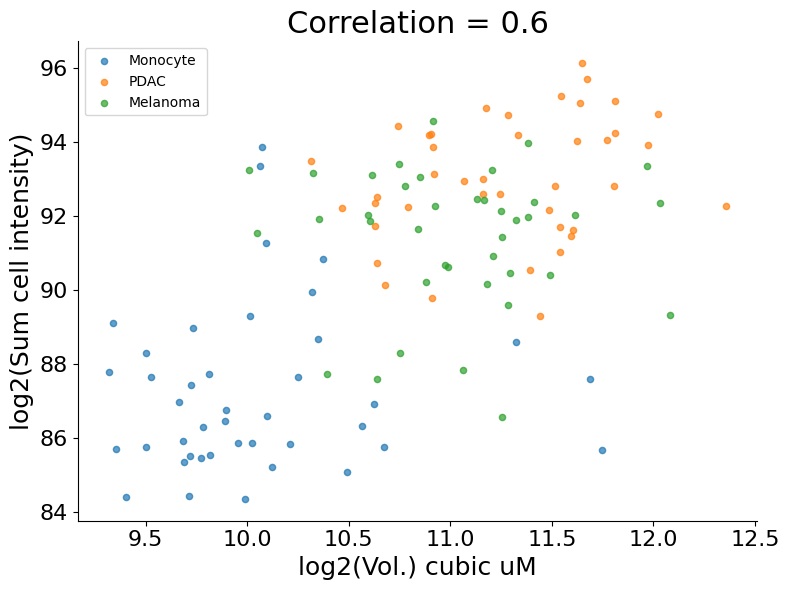

In [31]:
# Cell size vs total MS intensity
from quantqc.statistics import plot_cell_size_vs_intensity

fig = plot_cell_size_vs_intensity(AppNote, type_='sample')
plt.show()

### 1.7 Collapse to protein level

In [32]:
# opt=1: median of normalized peptides
from quantqc.normalize import collapse_to_protein

AppNote = collapse_to_protein(AppNote, opt=1)
print(f"Protein matrix: {AppNote.matrices.protein.shape[0]} proteins × {AppNote.matrices.protein.shape[1]} cells")

/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:48: RuntimeWarning: All-NaN slice encountered
  ref_vec = np.nanmedian(dat, axis=1)
/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:55: RuntimeWarning: Mean of empty slice
  m = np.nanmean(row)


Protein matrix: 4494 proteins × 121 cells


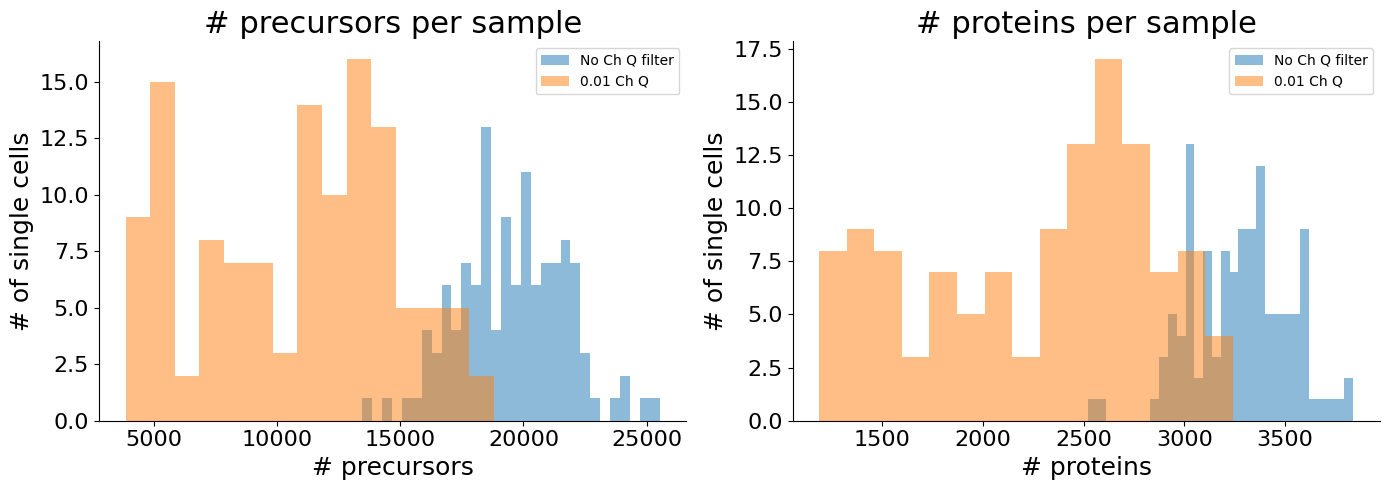

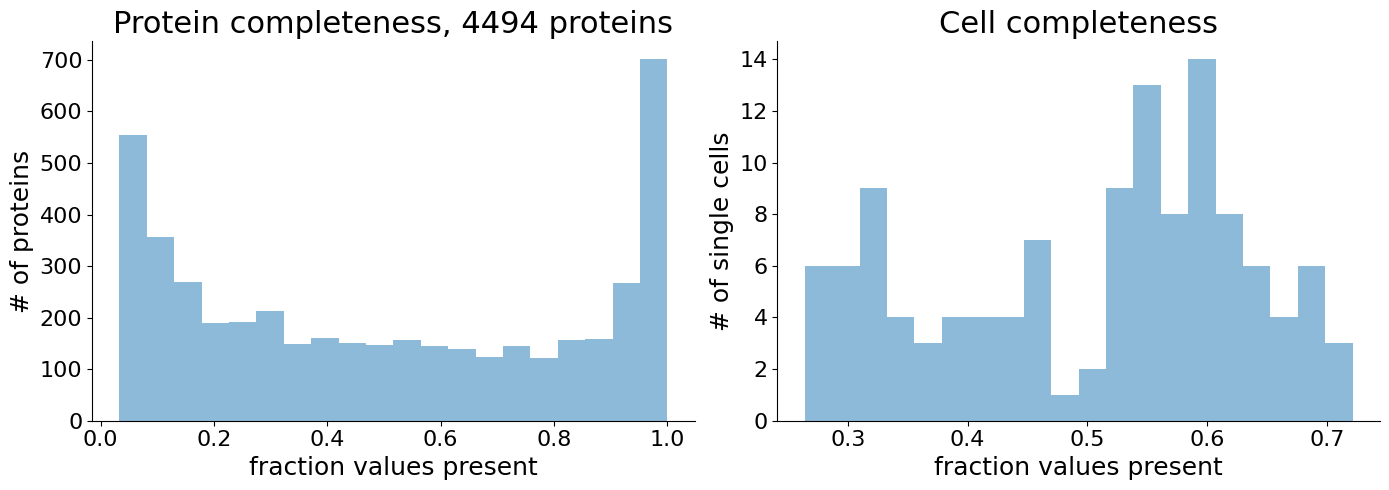

In [33]:
from quantqc.statistics import plot_prot_and_pep, plot_data_complete

fig = plot_prot_and_pep(AppNote)
plt.show()

fig = plot_data_complete(AppNote)
plt.show()

### 1.8 Peptide correlations

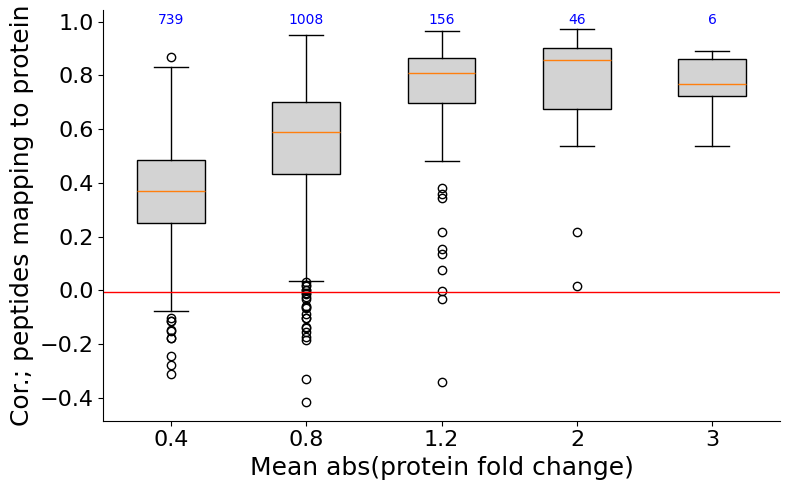

/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:48: RuntimeWarning: All-NaN slice encountered
  ref_vec = np.nanmedian(dat, axis=1)
/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:55: RuntimeWarning: Mean of empty slice
  m = np.nanmean(row)
/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:60: RuntimeWarning: invalid value encountered in log2
  dat = np.log2(dat)


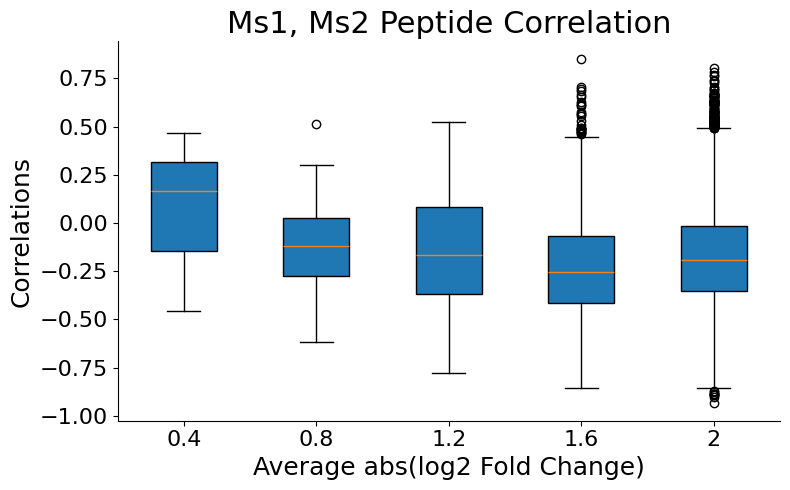

In [34]:
from quantqc.statistics import shared_peptide_cor, plot_pep_cor, plot_ms1_vs_ms2

AppNote = shared_peptide_cor(AppNote)

fig = plot_pep_cor(AppNote)
plt.show()

fig = plot_ms1_vs_ms2(AppNote)
plt.show()

### 1.9 Imputation and batch correction

In [35]:
from quantqc.normalize import knn_impute, batch_correct

AppNote = knn_impute(AppNote)
AppNote = batch_correct(AppNote, run=False, labels=True)
print("Imputation and batch correction complete.")

Imputation and batch correction complete.


### 1.10 PCA

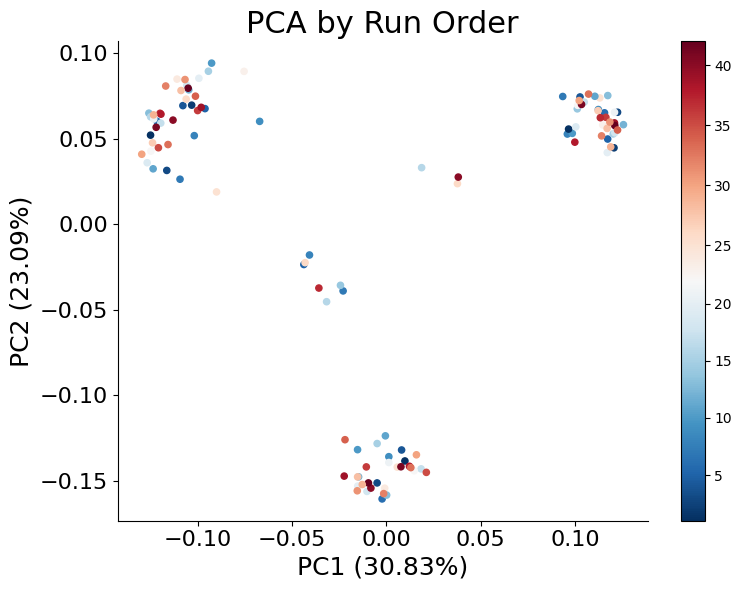

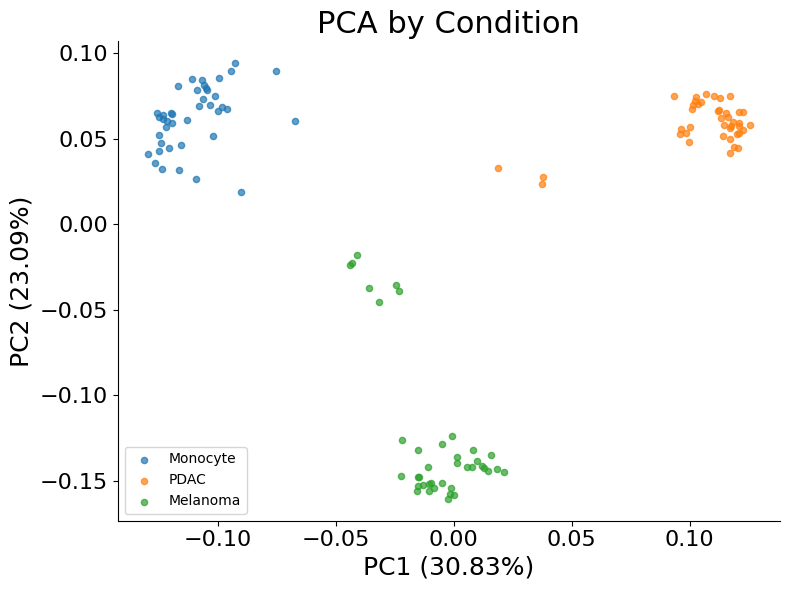

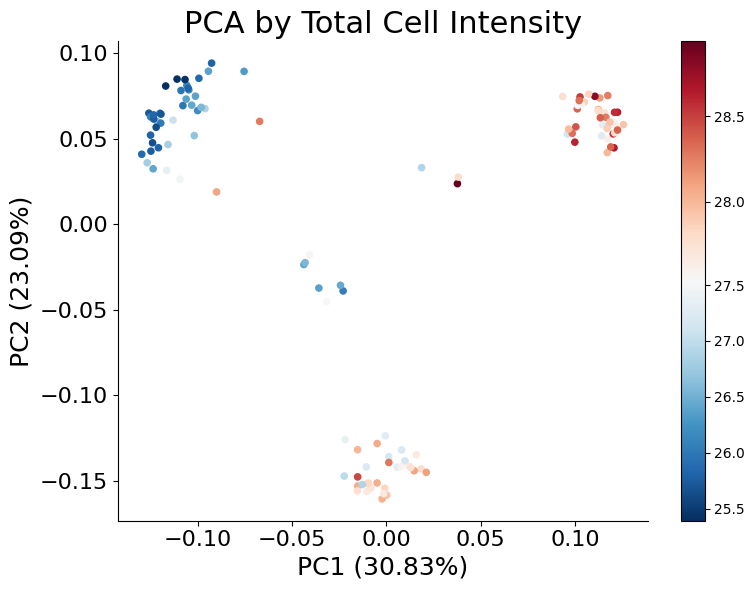

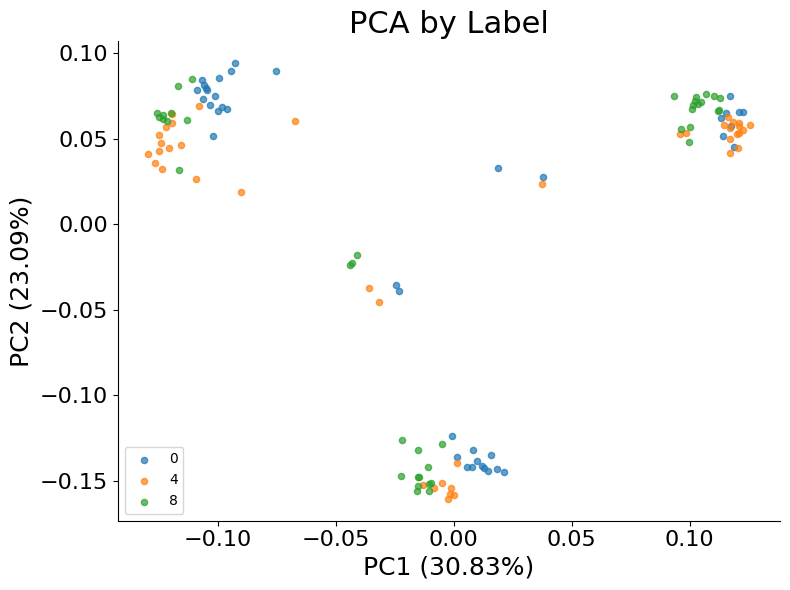

In [36]:
from quantqc.dimreduce import compute_pca, plot_pca

AppNote = compute_pca(AppNote)

for by in ["Run order", "Condition", "Total protein", "Label"]:
    fig = plot_pca(AppNote, by=by)
    plt.show()

### 1.11 UMAP

/Users/andrewleduc/anaconda3/envs/scp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrewleduc/anaconda3/envs/scp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


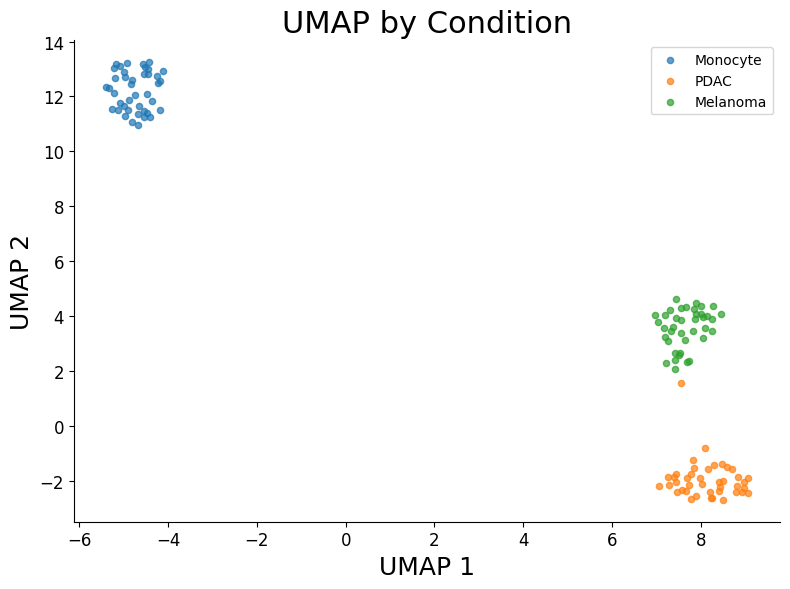

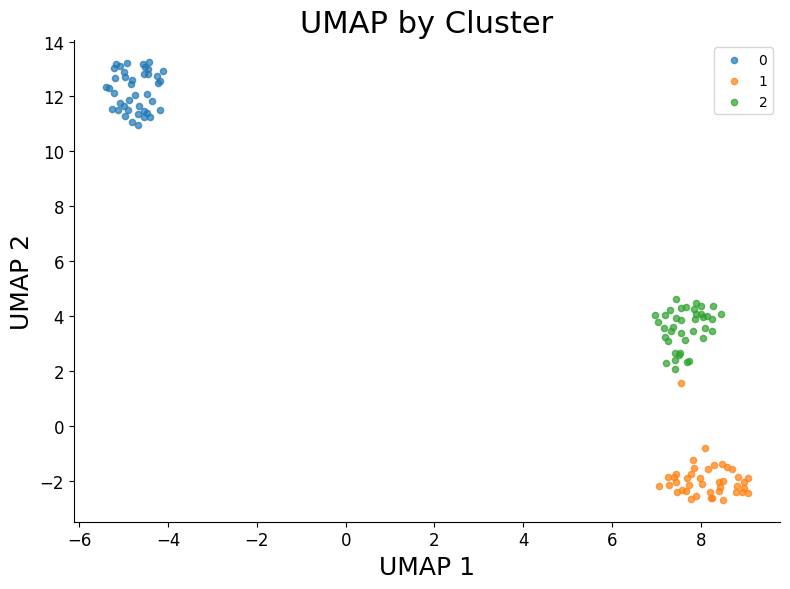

In [16]:
from quantqc.dimreduce import compute_umap, plot_umap, feature_umap

AppNote = compute_umap(AppNote)

fig = plot_umap(AppNote, by='Condition')
plt.show()

fig = plot_umap(AppNote, by='Cluster')
plt.show()

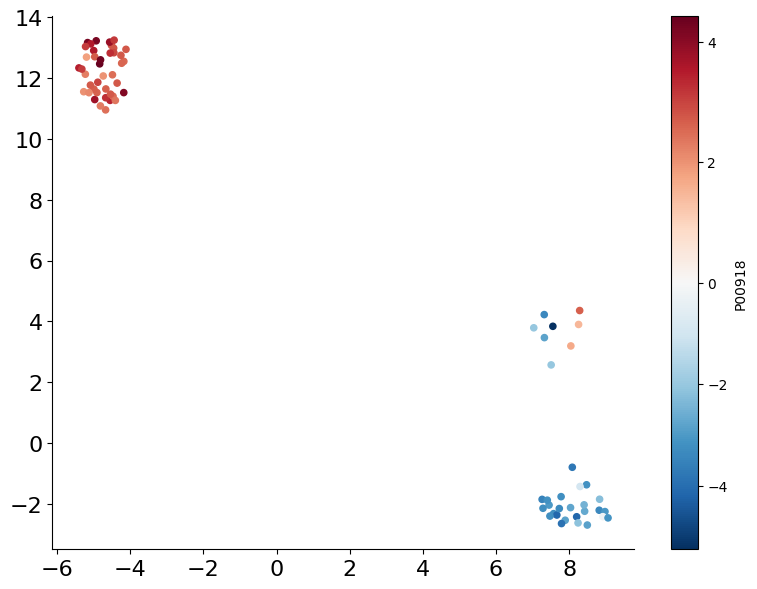

In [17]:
# Feature UMAP: color by a specific protein (Carbonic anhydrase 2)
fig = feature_umap(AppNote, prot='P00918', imputed=False)
plt.show()